# Introduction

This notebook demostrates the use of PAM to undertake facility sampling.

> Facility sampling allows us to convert activity locations from a zone- to point-basis, compatible with agent-based models' requirements. It allows us to stochastically distribute demand across appropriate candidate locations (typically extracted from OSM), following a set of rules such as land use and supply or cost weights.

In [1]:
import pandas as pd
import numpy as np
import os
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pam

from pam.samplers import facility

# Data

## Population

Load a dummy population to PAM:

In [4]:
from pam import read

In [5]:
# trips = pd.read_csv('example_data/example_travel_diaries.csv')
# attributes = pd.read_csv('example_data/example_attributes.csv')
# population = read.load_travel_diary(trips, attributes)

In [6]:
trips = pd.read_csv('tests/test_data/simple_travel_diaries.csv')
attributes = pd.read_csv('tests/test_data/simple_persons_data.csv')
population = read.load_travel_diary(trips, attributes)

In [7]:
print(population)

Population: 23 people in 20 households.


In [8]:
# population = read.load_travel_diary(
#     trip_diary=trips,
#     person_attributes=people_expanded,
#     hh_attributes=hhs_expanded
# )

In [9]:
trips.head()

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
0,0,0,1,a,a,b,work,car,500,530,10
1,0,0,2,a,b,a,work,car,1000,1030,10
2,1,0,1,a,a,b,work,car,500,530,10
3,1,0,2,a,b,a,work,car,800,830,10
4,1,0,3,a,a,c,other,car,1000,1030,10


In [10]:
attributes.head()

,pid,hsize,car,inc,hstr,gender,age,race,license,job,occ
0,0,3,car1,inc56,unknown,male,10,unknown,pdlcar,ft,occ1
1,1,3,car1,inc56,unknown,female,20,unknown,pdlcar,ft,occ2
2,2,3,car1,inc56,unknown,male,<10,unknown,pdlcar,ft,occ3
3,3,2,car0,inc34,2,unknown,30,unknown,other,pt,unknown
4,4,2,car0,inc34,2,female,30,white,other,ft,occ4


In [11]:
# from pam.plot.stats import plot_activity_times, plot_leg_times
# plot_activity_times(population)

In [12]:
[x for x in population.random_person().plan]

In [13]:
for act in population.random_person().plan.activities:
    print(act)

Activity(0 act:shop, location:b, time:00:00:00 --> 08:20:00, duration:8:20:00)
Activity(1 act:other, location:c, time:08:50:00 --> 13:20:00, duration:4:30:00)
Activity(2 act:home, location:a, time:13:50:00 --> 00:00:00, duration:10:10:00)


In [14]:
for i in population.random_person().plan:
    print(i)

Activity(0 act:escort, location:b, time:00:00:00 --> 08:20:00, duration:8:20:00)
Leg(0 mode:car, area:b --> b, time:08:20:00 --> 08:50:00, duration:0:30:00)
Activity(1 act:shop, location:b, time:08:50:00 --> 13:20:00, duration:4:30:00)
Leg(1 mode:car, area:b --> a, time:13:20:00 --> 13:50:00, duration:0:30:00)
Activity(2 act:home, location:a, time:13:50:00 --> 15:00:00, duration:1:10:00)
Leg(2 mode:car, area:a --> b, time:15:00:00 --> 15:30:00, duration:0:30:00)
Activity(3 act:escort, location:b, time:15:30:00 --> 00:00:00, duration:8:30:00)


In [15]:
[print(x) for x in population.random_person().plan.activities]

Activity(0 act:work, location:b, time:00:00:00 --> 08:20:00, duration:8:20:00)
Activity(1 act:shop, location:b, time:08:50:00 --> 13:20:00, duration:4:30:00)
Activity(2 act:home, location:a, time:13:50:00 --> 15:00:00, duration:1:10:00)
Activity(3 act:work, location:b, time:15:30:00 --> 00:00:00, duration:8:30:00)


[None, None, None, None]

In [16]:
print(population.random_person().plan.activities)

<generator object activities at 0x000001E9F6CFD048>


In [17]:
print(population.random_person().plan)

## Facilities

In [18]:
facilities = gp.read_file(os.path.join('sandbox','dummy_facilities.geojson'))
facilities['activity'] = ['home','home','work']

zones = gp.read_file(os.path.join('sandbox','dummy_zones.geojson'))
zones.set_index('zone', inplace = True)


In [19]:
facilities

,id,tags,features,geometry,activity
0,0,building:house,"{'acts': ['home'], 'units': 1, 'floors': 2, 'a...",POINT (1.00000 1.00000),home
1,7,"building:yes,landuse:residential","{'acts': ['home'], 'units': 20, 'floors': 2, '...",POINT (0.50000 0.50000),home
2,19,"building:yes,building:hospital,amenity:hospita...","{'acts': ['work', 'health', 'food_shop'], 'flo...",POINT (2.50000 2.50000),work


In [20]:
zones

,id,geometry
zone,,
a,1,"MULTIPOLYGON (((1.11538 -0.59699, -0.58974 0.2..."
b,2,"MULTIPOLYGON (((1.74359 3.18122, 3.63718 3.279..."


In [21]:
trips

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
0,0,0,1,a,a,b,work,car,500,530,10
1,0,0,2,a,b,a,work,car,1000,1030,10
2,1,0,1,a,a,b,work,car,500,530,10
3,1,0,2,a,b,a,work,car,800,830,10
4,1,0,3,a,a,c,other,car,1000,1030,10
...,...,...,...,...,...,...,...,...,...,...,...
57,21,18,1,a,b,c,work,car,500,1000,10
58,21,18,2,a,c,d,work,car,1100,1200,10
59,22,19,1,a,a,a,shop,car,500,530,10
60,22,19,2,a,a,b,work,car,600,630,10


In [22]:
trips.purp.unique()

array(['work', 'other', 'shop', 'escort'], dtype=object)

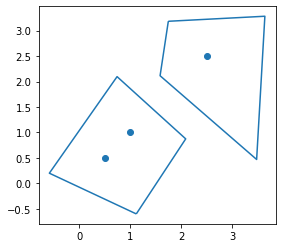

In [23]:
# plot facilities
fig, ax = plt.subplots(1,1)
zones.boundary.plot(ax=ax)
facilities.plot(ax=ax)
plt.show()

In [24]:
zones

,id,geometry
zone,,
a,1,"MULTIPOLYGON (((1.11538 -0.59699, -0.58974 0.2..."
b,2,"MULTIPOLYGON (((1.74359 3.18122, 3.63718 3.279..."


## Generate spatial data

In [25]:
trips

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
0,0,0,1,a,a,b,work,car,500,530,10
1,0,0,2,a,b,a,work,car,1000,1030,10
2,1,0,1,a,a,b,work,car,500,530,10
3,1,0,2,a,b,a,work,car,800,830,10
4,1,0,3,a,a,c,other,car,1000,1030,10
...,...,...,...,...,...,...,...,...,...,...,...
57,21,18,1,a,b,c,work,car,500,1000,10
58,21,18,2,a,c,d,work,car,1100,1200,10
59,22,19,1,a,a,a,shop,car,500,530,10
60,22,19,2,a,a,b,work,car,600,630,10


In [26]:
trips.purp.unique()

array(['work', 'other', 'shop', 'escort'], dtype=object)

In [27]:
zone_list = ['a','b','c','d','e','f','g','h','i']
activities_list = ['home','work', 'other', 'shop', 'escort']

In [28]:
facilities

,id,tags,features,geometry,activity
0,0,building:house,"{'acts': ['home'], 'units': 1, 'floors': 2, 'a...",POINT (1.00000 1.00000),home
1,7,"building:yes,landuse:residential","{'acts': ['home'], 'units': 20, 'floors': 2, '...",POINT (0.50000 0.50000),home
2,19,"building:yes,building:hospital,amenity:hospita...","{'acts': ['work', 'health', 'food_shop'], 'flo...",POINT (2.50000 2.50000),work


In [29]:
np.random.randint(1,4)

3

In [30]:
facilities.features[0]

{'acts': ['home'], 'units': 1, 'floors': 2, 'area': 47}

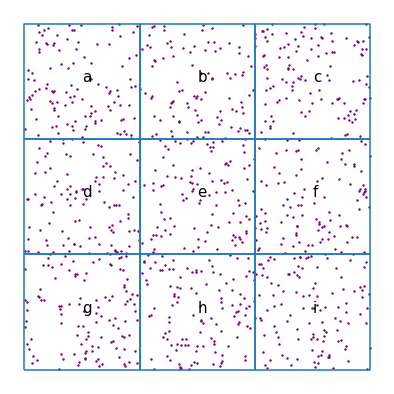

In [31]:
# create random spatial data

# create zones
l = 30
polygon_list = []

for y in [2*l,l,0]:
    for x in [0,l,2*l]:
        polygon_list.append(Polygon([[x,y],[x+l,y],[x+l,y+l],[x,y+l],[x,y]]))
        
zones = gp.GeoDataFrame(geometry = polygon_list)
zones['zone'] = zone_list
zones.set_index('zone', inplace = True)
# print(zones)


# create points
point_list = []
for activity in activities_list:
    for i in range(200):
        point = Point(np.random.rand() * 3 * l, np.random.rand() * 3 * l)
        point_list.append({'activity':activity,
                           'floors': np.random.randint(1,4),
                           'units': np.random.randint(1,20),
                           'area': np.random.randint(1,100),
                           'transit': np.random.randint(1,10000),                           
                           'geometry':point})
            
points = gp.GeoDataFrame(point_list)
points = gp.sjoin(points, zones.reset_index()).drop(columns='index_right')

# print(points)

# plot
fig, ax = plt.subplots(1,1, figsize = (10,7))
zones.boundary.plot(ax = ax)
points.plot(ax=ax, markersize=2, color='purple')
for zone, centroid in zip(zones.index, zones.centroid):
    ax.annotate(zone, xy = (centroid.x, centroid.y), size = 15)
ax.axis('off')
plt.show()

In [32]:
# create facility points

In [33]:
# expand facilities
facilities_expanded = []
for i, irow in facilities.iterrows():
    no_acts = len(irow.features['acts'])
    for act in irow.features['acts']:
        facilities_expanded.append({
            'act': act,
            'area' : irow.features['area'] / no_acts
        })
facilities_expanded = pd.DataFrame(facilities_expanded)
facilities_expanded

,act,area
0,home,47.000000
1,home,800.000000
2,work,66.666667
3,health,66.666667
4,food_shop,66.666667


# Tabular Sampling

In [34]:
activity

'escort'

In [35]:
def df_sample(x):
    return x.sample(10, weights = x.area + 0.001)

points.groupby('zone').apply(df_sample)

activity  floors  units  area  transit                   geometry  \
zone                                                                         
a    830   escort       3     14     5     4051  POINT (22.63945 88.39586)   
     468    other       3      9    45     1381  POINT (16.10867 63.44523)   
     891   escort       1     12    19     1422   POINT (1.93630 71.36279)   
     730     shop       1     17    51     3373  POINT (12.30325 88.39470)   
     669     shop       2      6    23       96   POINT (7.71153 67.56657)   
...           ...     ...    ...   ...      ...                        ...   
i    413    other       3     15    70     5405  POINT (67.32865 20.54444)   
     541    other       1     19    49     7423  POINT (71.80680 29.17439)   
     563    other       2      2    80     6231  POINT (72.26837 26.42227)   
     443    other       2     17    13     7650  POINT (70.03533 25.36353)   
     711     shop       1      8     3     7692  POINT (73.99010 12.02159)   

         zone  
zone           
a    830    a  
     468    a  
     891    a  
     730    a  
     669    a  
...       ...  
i    413    i  
     541    i  
     563    i  
     443    i  
     711    i  

[90 rows x 7 columns]

In [36]:
points[(points.zone=='a') & (points.activity=='home')]

,activity,floors,units,area,transit,geometry,zone
1,home,1,11,98,9836,POINT (7.41548 72.31658),a
8,home,2,12,31,6196,POINT (5.64507 85.03755),a
37,home,3,2,89,5977,POINT (24.13406 61.56106),a
47,home,3,8,29,8852,POINT (27.76352 73.58084),a
48,home,3,10,50,8565,POINT (8.19527 63.31716),a
62,home,2,2,20,4160,POINT (15.73319 65.94636),a
67,home,2,6,44,6482,POINT (11.05986 86.03223),a
91,home,1,7,2,7228,POINT (25.26849 79.00136),a
95,home,2,6,50,1196,POINT (5.15340 88.39901),a
98,home,2,7,2,5339,POINT (2.72608 72.55226),a


In [37]:
# first, sample household locations
hh_locs = trips[['hid','hzone']].drop_duplicates()
hh_locs = pd.merge(hh_locs, points[points.activity=='home'], left_on='hzone',right_on='zone')
hh_locs = hh_locs.groupby('hid').apply(lambda x: x.sample(1, weights = x.area))

hh_locs

,,hid,hzone,activity,floors,units,area,transit,geometry,zone
hid,,,,,,,,,,
0,16,0,a,home,2,1,86,6378,POINT (15.35121 81.34697),a
1,367,1,b,home,1,6,87,2493,POINT (37.06396 84.84169),b
2,27,2,a,home,2,6,50,1196,POINT (5.15340 88.39901),a
3,40,3,a,home,3,2,89,5977,POINT (24.13406 61.56106),a
4,58,4,a,home,2,12,31,6196,POINT (5.64507 85.03755),a
5,76,5,a,home,1,11,98,9836,POINT (7.41548 72.31658),a
6,112,6,a,home,1,10,43,7754,POINT (0.93706 77.83128),a
7,116,7,a,home,3,2,89,5977,POINT (24.13406 61.56106),a
8,137,8,a,home,3,10,50,8565,POINT (8.19527 63.31716),a


In [38]:
trips

,pid,hid,seq,hzone,ozone,dzone,purp,mode,tst,tet,freq
0,0,0,1,a,a,b,work,car,500,530,10
1,0,0,2,a,b,a,work,car,1000,1030,10
2,1,0,1,a,a,b,work,car,500,530,10
3,1,0,2,a,b,a,work,car,800,830,10
4,1,0,3,a,a,c,other,car,1000,1030,10
...,...,...,...,...,...,...,...,...,...,...,...
57,21,18,1,a,b,c,work,car,500,1000,10
58,21,18,2,a,c,d,work,car,1100,1200,10
59,22,19,1,a,a,a,shop,car,500,530,10
60,22,19,2,a,a,b,work,car,600,630,10


In [39]:
# combine with trips
trips_sampled = pd.merge(
    trips,
    hh_locs[['geometry']].reset_index(),
    on='hid'
)

# expand for possible locations
trips_sampled = pd.merge(
    trips_sampled,
    points,
    right_on = ['zone', 'activity'],
    left_on = ['dzone','purp'],
    suffixes = ['_home','_d']
)

# calculate distance
trips_sampled['distance'] = trips_sampled.apply(lambda x: x.geometry_d.distance(x.geometry_home), axis=1) 

# calcualte weight
trips_sampled['weight'] = trips_sampled['area'] / trips_sampled['distance']
# weight to zero if too far from PT stop
trips_sampled['weight'] = np.where(
    (trips_sampled['transit'] > 2000) & (trips_sampled['mode']=='bus'),
    0,
    trips_sampled['weight']
)
# don't walk too far
trips_sampled['weight'] = np.where(
    (trips_sampled['distance'] > 4000) & (trips_sampled['mode']=='walk'),
    0,
    trips_sampled['weight']
)

# sample
trips_sampled = trips_sampled.groupby(['pid','seq']).apply(lambda x: x.sample(1, weights = x.weight))

trips_sampled

pid  hid  seq hzone ozone dzone   purp mode   tst   tet  ...  \
pid seq                                                                ...   
0   1   7       0    0    1     a     a     b   work  car   500   530  ...   
    2   242     0    0    2     a     b     a   work  car  1000  1030  ...   
1   1   20      1    0    1     a     a     b   work  car   500   530  ...   
    2   264     1    0    2     a     b     a   work  car   800   830  ...   
    3   460     1    0    3     a     a     c  other  car  1000  1030  ...   
...           ...  ...  ...   ...   ...   ...    ...  ...   ...   ...  ...   
21  1   665    21   18    1     a     b     c   work  car   500  1000  ...   
    2   934    21   18    2     a     c     d   work  car  1100  1200  ...   
22  1   1107   22   19    1     a     a     a   shop  car   500   530  ...   
    2   221    22   19    2     a     a     b   work  car   600   630  ...   
    3   457    22   19    3     a     b     a   work  car   900   945  ...   

                          geometry_home  activity floors units  area  transit  \
pid seq                                                                         
0   1   7     POINT (15.35121 81.34697)      work      1     6    84     5876   
    2   242   POINT (15.35121 81.34697)      work      1     9    83     9907   
1   1   20    POINT (15.35121 81.34697)      work      2    13    39     8213   
    2   264   POINT (15.35121 81.34697)      work      1    16    48      511   
    3   460   POINT (15.35121 81.34697)     other      2     4    40     9899   
...                                 ...       ...    ...   ...   ...      ...   
21  1   665    POINT (8.19527 63.31716)      work      3     8    89     6971   
    2   934    POINT (8.19527 63.31716)      work      3     8    80     2361   
22  1   1107   POINT (5.64507 85.03755)      shop      2    12    93     2315   
    2   221    POINT (5.64507 85.03755)      work      3     9    98     7892   
    3   457    POINT (5.64507 85.03755)      work      2     8    77     5897   

                             geometry_d  zone   distance     weight  
pid seq                                                              
0   1   7     POINT (56.06122 62.96130)     b  44.669201   1.880490  
    2   242   POINT (15.08483 70.28255)     a  11.067627   7.499349  
1   1   20    POINT (48.76940 75.75142)     b  33.883409   1.151006  
    2   264   POINT (28.77965 73.86014)     a  15.374515   3.122050  
    3   460   POINT (71.45500 70.05168)     c  57.229530   0.698940  
...                                 ...   ...        ...        ...  
21  1   665   POINT (80.08451 69.37098)     c  72.143682   1.233649  
    2   934    POINT (0.83114 34.04112)     d  30.188022   2.650058  
22  1   1107  POINT (22.68034 89.03400)     a  17.497771   5.314963  
    2   221   POINT (45.84910 70.27308)     b  42.829360   2.288150  
    3   457    POINT (3.78450 83.27122)     a   2.565464  30.014058  

[62 rows x 22 columns]

<AxesSubplot:>

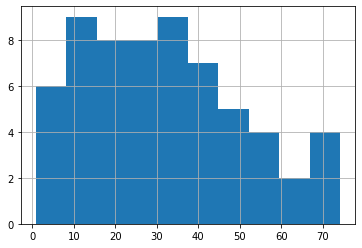

In [40]:
trips_sampled.distance.hist()

In [42]:
# trips_sampled.geometry[0].distance(trips_sampled.geometry[10])

In [43]:
facilities.features[2]

{'acts': ['work', 'health', 'food_shop'],
 'floors': 4,
 'area': 200,
 'transit': 120}

In [44]:
import seaborn as sns

In [46]:
# # demo location choice likehood function
# n = 20
# (np.array(range(0,n)) + 1).dot((np.array(range(0,n)) + 1).reshape(1,-1))


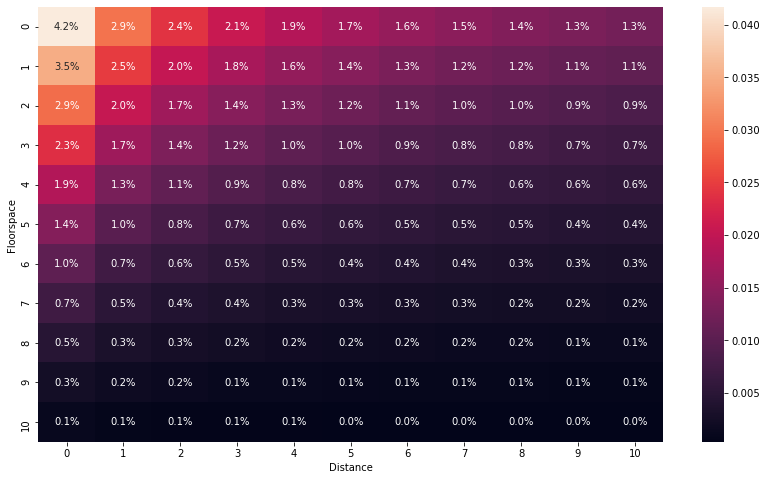

In [47]:
n = 11
decay_factor = 0.5
fs_power = 2

f = (np.array(range(n,0,-1)) + 1).reshape(-1,1) ** fs_power
d = ((np.array(range(0,n)) + 1)).reshape(1,-1) ** decay_factor
p = (f).dot(1/d)
p = p / p.sum().sum()

plt.figure(figsize=(14,8))
sns.heatmap(p, annot=True, fmt='.1%')
plt.ylabel('Floorspace')
plt.xlabel('Distance')
plt.show()

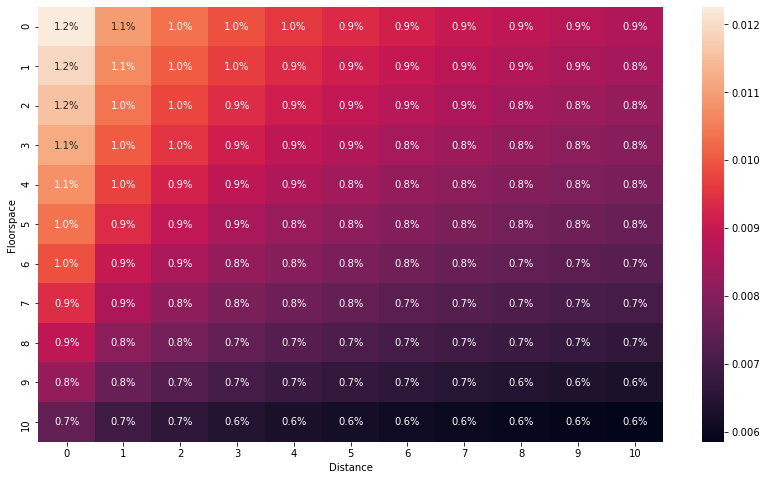

In [48]:
# as above, logit
n = 11
decay_factor = 0.1
fs_power = 0.2

f = (np.array(range(n,0,-1)) + 1).reshape(-1,1) ** fs_power
d = ((np.array(range(0,n)) + 1)).reshape(1,-1) ** decay_factor
p = np.exp((f).dot(1/d))
p = p / p.sum().sum()

plt.figure(figsize=(14,8))
sns.heatmap(p, annot=True, fmt='.1%')
plt.ylabel('Floorspace')
plt.xlabel('Distance')
plt.show()

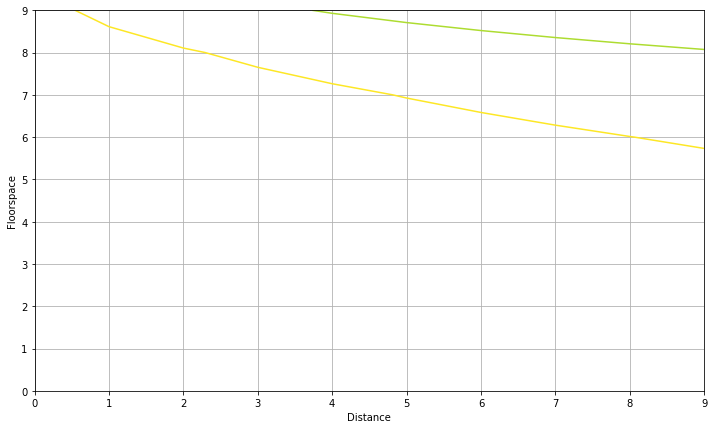

In [49]:
n = 10
decay_factor = 0.1
fs_power = 0.2

f = (np.array(range(n,0,-1)) + 1).reshape(-1,1) ** fs_power
d = ((np.array(range(0,n)) + 1)).reshape(1,-1) ** decay_factor
p = (f).dot(1/d)
p = p / p.sum().sum()

plt.figure(figsize=(12,7))
plt.contour(p, levels=[x/n/100 for x in range(1,10)],extend='both')
plt.grid()
plt.ylabel('Floorspace')
plt.xlabel('Distance')
plt.show()

In [50]:
p

array([[0.01313511, 0.01225549, 0.01176852, 0.01143478, 0.01118245,
        0.01098041, 0.01081245, 0.01066903, 0.0105441 , 0.01043359],
       [0.0128871 , 0.01202409, 0.01154631, 0.01121887, 0.01097131,
        0.01077309, 0.01060829, 0.01046758, 0.01034501, 0.01023659],
       [0.01261839, 0.01177337, 0.01130555, 0.01098494, 0.01074254,
        0.01054845, 0.01038709, 0.01024931, 0.0101293 , 0.01002314],
       [0.01232461, 0.01149927, 0.01104234, 0.0107292 , 0.01049244,
        0.01030287, 0.01014527, 0.0100107 , 0.00989348, 0.00978979],
       [0.01199983, 0.01119623, 0.01075134, 0.01044645, 0.01021593,
        0.01003136, 0.00987791, 0.00974689, 0.00963276, 0.0095318 ],
       [0.01163551, 0.01085632, 0.01042494, 0.0101293 , 0.00990578,
        0.00972681, 0.00957802, 0.00945097, 0.00934031, 0.00924242],
       [0.01121887, 0.01046758, 0.01005165, 0.0097666 , 0.00955108,
        0.00937852, 0.00923506, 0.00911256, 0.00900586, 0.00891147],
       [0.0107292 , 0.0100107 , 0.0096129

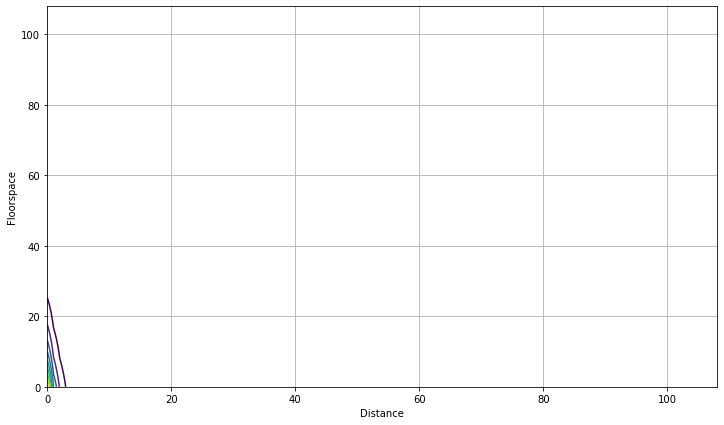

In [51]:
n = 110
decay_factor = 1
fs_power = 1

f = (np.array(range(n,1,-1)) + 10).reshape(-1,1) ** fs_power
d = ((np.array(range(1,n)) + 10)).reshape(1,-1) ** decay_factor
p = np.exp((f).dot(1/d))
p = p / p.max().max()

plt.figure(figsize=(12,7))
plt.contour(p, levels=[x/10 for x in range(1,10)],extend='both')
plt.grid()
plt.ylabel('Floorspace')
plt.xlabel('Distance')
plt.show()

# Facility Sampling

In [53]:
# facility_sampler = facility.FacilitySampler(
#     facilities=facilities,
#     zones=zones,
#     build_xml=True,
#     fail=False,
#     random_default=True
#     )

<AxesSubplot:>

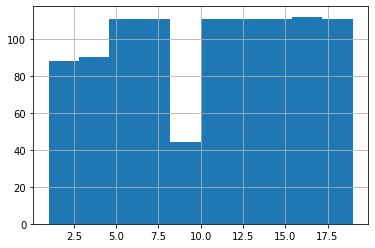

In [54]:
points.units.hist()

In [55]:
points

,activity,floors,units,area,transit,geometry,zone
0,home,3,1,92,9278,POINT (84.53651 64.87446),c
6,home,2,6,34,7648,POINT (77.19143 86.53923),c
19,home,1,15,10,2428,POINT (65.73086 69.53914),c
27,home,1,13,14,5724,POINT (62.62027 60.00793),c
34,home,2,13,86,2433,POINT (79.67897 60.15292),c
...,...,...,...,...,...,...,...
979,escort,2,11,34,2530,POINT (59.59184 17.84344),h
987,escort,3,1,92,9197,POINT (57.32592 2.37754),h
992,escort,1,9,73,1648,POINT (58.43742 25.68907),h
998,escort,1,3,42,4632,POINT (37.19632 8.02566),h


In [95]:
facility_sampler_nonweighted = facility.FacilitySampler(
    facilities=points,
    zones=zones,
    build_xml=True,
    fail=False,
    random_default=True
    )

Joining facilities data to zones, this may take a while.
Building sampler, this may take a while.


In [56]:
facility_sampler = facility.FacilitySampler(
    facilities=points,
    zones=zones,
    build_xml=True,
    fail=False,
    random_default=True,
    weight_on = 'area'
    )

Joining facilities data to zones, this may take a while.
Building sampler, this may take a while.


In [57]:
# sample population

population.sample_locs(facility_sampler)

<AxesSubplot:>

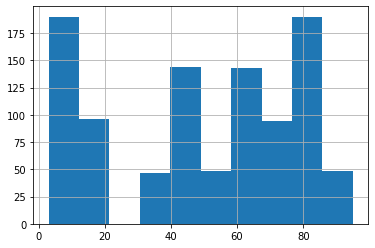

In [96]:
s = []
for i in range(1000):
    idx, point = next(facility_sampler_nonweighted.samplers['a']['work'])
    s.append(points.loc[idx].area)
pd.Series(s).hist()

<AxesSubplot:>

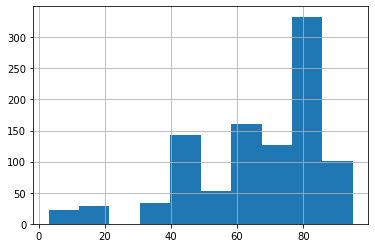

In [97]:
s = []
for i in range(1000):
    idx, point = next(facility_sampler.samplers['a']['work'])
    s.append(points.loc[idx].area)
pd.Series(s).hist()

In [94]:
facility_sampler.samplers

{'c': {'other': <generator object inf_yielder at 0x000001E9FB3C0620>,
  'home': <generator object inf_yielder at 0x000001E9FB3C0728>,
  'work': <generator object inf_yielder at 0x000001E9FB4B19E8>,
  'escort': <generator object inf_yielder at 0x000001E9FB4B1A98>,
  'shop': <generator object inf_yielder at 0x000001E9FB4B1A40>},
 'b': {'other': <generator object inf_yielder at 0x000001E9FB4B18E0>,
  'home': <generator object inf_yielder at 0x000001E9FB4B1990>,
  'work': <generator object inf_yielder at 0x000001E9FB4B1BA0>,
  'escort': <generator object inf_yielder at 0x000001E9FB4B1BF8>,
  'shop': <generator object inf_yielder at 0x000001E9FB4B1C50>},
 'f': {'other': <generator object inf_yielder at 0x000001E9FB4B1CA8>,
  'home': <generator object inf_yielder at 0x000001E9FB4B1D00>,
  'work': <generator object inf_yielder at 0x000001E9FB4B1D58>,
  'escort': <generator object inf_yielder at 0x000001E9FB4B1DB0>,
  'shop': <generator object inf_yielder at 0x000001E9FB4B1E08>},
 'a': {'other

In [61]:
import random

In [62]:
a = [1,2,3,4,5]
random.shuffle(a)
a

[3, 2, 1, 4, 5]

In [63]:
a = [1,2,3,4,5]
def t(x):
    while True:
        random.shuffle(x)
        yield x
        
t = t(a)
next(t)

[5, 1, 2, 4, 3]

In [64]:
if a == None:
    print(a)

In [65]:
np.random.choice(a)

4

In [66]:
a = [1,2,3,4,5]
def t(x):
    while True:        
        yield np.random.choice(x, p = [0.1,0.1,0.1,0.1,0.6])
        
t = t(a)
next(t)

5

In [67]:
points

,activity,floors,units,area,transit,geometry,zone
0,home,3,1,92,9278,POINT (84.53651 64.87446),c
6,home,2,6,34,7648,POINT (77.19143 86.53923),c
19,home,1,15,10,2428,POINT (65.73086 69.53914),c
27,home,1,13,14,5724,POINT (62.62027 60.00793),c
34,home,2,13,86,2433,POINT (79.67897 60.15292),c
...,...,...,...,...,...,...,...
979,escort,2,11,34,2530,POINT (59.59184 17.84344),h
987,escort,3,1,92,9197,POINT (57.32592 2.37754),h
992,escort,1,9,73,1648,POINT (58.43742 25.68907),h
998,escort,1,3,42,4632,POINT (37.19632 8.02566),h


In [68]:
facilities

,id,tags,features,geometry,activity
0,0,building:house,"{'acts': ['home'], 'units': 1, 'floors': 2, 'a...",POINT (1.00000 1.00000),home
1,7,"building:yes,landuse:residential","{'acts': ['home'], 'units': 20, 'floors': 2, '...",POINT (0.50000 0.50000),home
2,19,"building:yes,building:hospital,amenity:hospita...","{'acts': ['work', 'health', 'food_shop'], 'flo...",POINT (2.50000 2.50000),work


In [69]:
for i in range(10):
    print(next(t))

4
5
5
5
1
5
4
5
5
5


In [70]:
next(t)

3

In [71]:
sum(a)

15

In [72]:
next(t)

2

In [73]:
np.random.choice(a)

5

In [74]:
next(t)

1

In [76]:
# [x for x in t]

In [77]:
# next(t)

In [78]:
# next(t)

In [79]:
a

[1, 2, 3, 4, 5]

In [80]:
next(facility_sampler.samplers['d']['home'])

(112, <shapely.geometry.point.Point at 0x1e9f9e73c18>)

In [81]:
for i in range(10):
    print(next(facility_sampler.samplers['d']['home']))

(100, <shapely.geometry.point.Point object at 0x000001E9F9E73978>)
(199, <shapely.geometry.point.Point object at 0x000001E9F9E8EF60>)
(105, <shapely.geometry.point.Point object at 0x000001E9F9E73A90>)
(182, <shapely.geometry.point.Point object at 0x000001E9F9E8EBA8>)
(153, <shapely.geometry.point.Point object at 0x000001E9F9E8E550>)
(161, <shapely.geometry.point.Point object at 0x000001E9F9E8E710>)
(54, <shapely.geometry.point.Point object at 0x000001E9F9E68FD0>)
(9, <shapely.geometry.point.Point object at 0x000001E9F9E685C0>)
(105, <shapely.geometry.point.Point object at 0x000001E9F9E73A90>)
(9, <shapely.geometry.point.Point object at 0x000001E9F9E685C0>)


In [82]:
facility_sampler.samplers['a']['home']

<generator object inf_yielder at 0x000001E9FB4B1EB8>

In [83]:
# sample single facility
facility_sampler.sample('i','work').xy

(array('d', [77.27030874346801]), array('d', [3.813730816746369]))

In [84]:
facility_sampler.activities

['other', 'home', 'work', 'escort', 'shop']

In [85]:
# facility_sampler.facilities

In [86]:
# facility_sampler.sample_facility(1,'home')

In [87]:
print(population.random_person().plan[0])

Activity(0 act:work, location:POINT (45.849104508431 70.27307931179966), time:00:00:00 --> 08:20:00, duration:8:20:00)


In [88]:
person = population.households['0'].people['0']
acts = [x for x in person.plan.activities]
acts[0].location.loc.x

3.0219319836821157

In [89]:
population.random_person().plan[0].location.loc.x

45.18607299439347

In [100]:
def yielder(x):
    while True:
        random.shuffle(x)
        for c in x:
            yield c
            
i_yielder = yielder(a)
for i in range(10):
    print(next(i_yielder))

2
1
3
5
4
5
1
4
3
2


In [111]:
def test_printer():
    return lambda x: print(x)

tp = test_printer()
tp('hi')

hi


In [116]:
def test_message(x,y):
    print(x,y)

def test_printer():
    return test_message

tp = test_printer()
tp('hi','there')

hi there


In [104]:
def yielder_options(x):
    while True:
        random.shuffle(x)
        for c in x:
            yield c
            
i_yielder_options = yielder_options(a)
for i in range(10):
    print(next(i_yielder_options, 'hi'))

3
5
1
4
2
4
5
1
2
3


In [ ]:
def random_yielder(zone):
    print('random location in',zone)
    
def weighted_yielder(zone, weights):
    print('weighted sample in zone',zone,'with weights', weights)

def pt_yielder(zone):
    print('use pt restriction in zone',zone)
    
def select_yielder(yielder_version):
    return yielder_version

sample_dict = select_yielder(pt_yielder)
sample_dict('a')

sample_dict = select_yielder(weighted_yielder)
sample_dict('a',[0.5,0.3,0.2])

use pt restriction in zone a
weighted sample in zone a with weights [0.5, 0.3, 0.2]


## Weighted by floor space

## Origin-Destination sampling